In [1]:
%load_ext autoreload
%autoreload 2
from data_processing import *

from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error,mean_absolute_percentage_error
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import optuna
import os
import numpy as np
from tqdm import tqdm
import copy
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQUENCE_LENGTH = 144
PREDICT_LENGTH = 1
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 200
PATIENCE = 20


In [2]:
##########################################################
# Data loading
##########################################################
data_dir = "../01_Datenaufbereitung/Output/Calculated/"
all_data = load_data(data_dir)

train_df, val_df, test_df = split_data(all_data, train=13, val=1, test=1, parts = 1)
train_scaled, val_scaled, test_scaled = scale_data(train_df, val_df, test_df)


Found 15 parquet files


Processing cells:   0%|          | 0/15 [00:00<?, ?cell/s]

Processing C01 ...


Processing cells:   7%|▋         | 1/15 [00:14<03:16, 14.07s/cell]

Processing C03 ...


Processing cells:  13%|█▎        | 2/15 [00:22<02:17, 10.57s/cell]

Processing C05 ...


Processing cells:  20%|██        | 3/15 [00:29<01:51,  9.27s/cell]

Processing C07 ...


Processing cells:  27%|██▋       | 4/15 [00:38<01:37,  8.90s/cell]

Processing C09 ...


Processing cells:  33%|███▎      | 5/15 [00:42<01:10,  7.08s/cell]

Processing C11 ...


Processing cells:  40%|████      | 6/15 [00:46<00:54,  6.11s/cell]

Processing C13 ...


Processing cells:  47%|████▋     | 7/15 [00:47<00:37,  4.64s/cell]

Processing C15 ...


Processing cells:  53%|█████▎    | 8/15 [00:49<00:26,  3.81s/cell]

Processing C17 ...


Processing cells:  60%|██████    | 9/15 [00:57<00:30,  5.01s/cell]

Processing C19 ...


Processing cells:  67%|██████▋   | 10/15 [01:04<00:28,  5.72s/cell]

Processing C21 ...


Processing cells:  73%|███████▎  | 11/15 [01:11<00:24,  6.10s/cell]

Processing C23 ...


Processing cells:  80%|████████  | 12/15 [01:19<00:19,  6.46s/cell]

Processing C25 ...


Processing cells:  87%|████████▋ | 13/15 [01:24<00:12,  6.04s/cell]

Processing C27 ...


Processing cells:  93%|█████████▎| 14/15 [01:31<00:06,  6.43s/cell]

Processing C29 ...


Processing cells: 100%|██████████| 15/15 [01:36<00:00,  6.43s/cell]


Cell split completed:
Training set: 13 cells
Validation set: 1 cells
Test set: 1 cells
Final dataset sizes:
Training set: 285880 rows (split into 13 parts)
Validation set: 26791 rows from 1 cells
Test set: 27189 rows from 1 cells


In [3]:
### Visualize data
# visualize_data(all_data)
# inspect_data_ranges(all_data)
# inspect_data_ranges(train_scaled)
# plot_dataset_soh(train_df, "Train")
# plot_dataset_soh(val_df, "Validation")
# plot_dataset_soh(test_df, "Test")
test_scaled

,Testtime[min],Current[A],Voltage[V],Temperature[°C],cell_id,SOH_ZHU
190855,0,0.367775,-4.470896,1.112695,C19,0.999996
190856,1,0.871294,0.079981,0.016040,C19,0.999986
190857,2,0.871286,0.459221,-0.163084,C19,0.999973
190858,3,0.871258,0.590494,-0.072661,C19,0.999961
190859,4,0.871295,0.653840,0.115139,C19,0.999948
...,...,...,...,...,...,...
218039,27184,-0.134704,-0.347841,-0.673595,C19,0.839529
218040,27185,-0.145455,-0.380731,-0.663063,C19,0.839529
218041,27186,-0.109405,-0.364477,-0.650688,C19,0.839529
218042,27187,-0.059426,-0.278636,-0.654852,C19,0.839529


In [4]:
##########################################################
# Dataset definition    
##########################################################
class CellDataset(Dataset):
    def __init__(self, df, sequence_length=60, pred_len=1, stride=1):
        self.sequence_length = sequence_length
        self.pred_len = pred_len
        # Specify feature columns and label column
        features_cols = ['Voltage[V]', 'Current[A]', 'Temperature[°C]']
        label_col = 'SOH_ZHU'
        cell_id_col = 'cell_id'
        
        # Initialize lists to store features and labels
        self.features = []
        self.labels = []
        
        # Process each cell separately
        for cell_id in df[cell_id_col].unique():
            # Get data for current cell
            cell_data = df[df[cell_id_col] == cell_id].sort_index()
            
            # Convert to tensors
            cell_features = torch.tensor(cell_data[features_cols].values, dtype=torch.float32)
            cell_labels = torch.tensor(cell_data[label_col].values, dtype=torch.float32)
            
            # Calculate number of possible windows
            n_samples = len(cell_data) - sequence_length - pred_len + 1
            
            if n_samples > 0:
                # Create sliding windows
                for i in range(0, n_samples, stride):
                    # Input sequence
                    feature_window = cell_features[i:i + sequence_length]
                    # Prediction target
                    label_window = cell_labels[i + sequence_length:i + sequence_length + pred_len]
                    
                    self.features.append(feature_window)
                    self.labels.append(label_window)
        
        # Convert lists to tensors
        self.features = torch.stack(self.features)  # (n_samples, sequence_length, n_features)
        self.labels = torch.stack(self.labels)      # (n_samples, pred_len)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


train_dataset = CellDataset(train_scaled, SEQUENCE_LENGTH, PREDICT_LENGTH)
val_dataset = CellDataset(val_scaled, SEQUENCE_LENGTH, PREDICT_LENGTH)
test_dataset = CellDataset(test_scaled, SEQUENCE_LENGTH, PREDICT_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=torch.cuda.is_available())


In [ ]:
##########################################################  
# Model definition  
##########################################################
# 1. LSTM one/multi step prediction model
class SOHLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(SOHLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Fully connected layer
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Only take the output from the last time
        out = lstm_out[:, -1, :]  # The shape: [batch_size, hidden_size]

        # Through the fully connected layer
        out = self.fc_layers(out)
        
        return out.squeeze(-1), _

# # 2. LSTM with attention prediction model
# class AttentionLayer(nn.Module):
#     def __init__(self, hidden_dim):
#         super(AttentionLayer, self).__init__()
#         self.hidden_dim = hidden_dim
#         # 前馈网络：先降维，再经过 Tanh 激活，最后映射到标量注意力得分
#         self.attention = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             nn.Tanh(),
#             nn.Linear(hidden_dim // 2, 1)
#         )
        
#     def forward(self, lstm_output):
#         """
#         Args:
#             lstm_output: [batch_size, seq_len, hidden_dim]
#         Returns:
#             context: [batch_size, hidden_dim]，加权求和后的上下文向量
#             attn_weights: [batch_size, seq_len, 1]，归一化的注意力权重
#         """
#         # 计算每个时间步的注意力得分
#         attn_scores = self.attention(lstm_output)  # 形状: (batch_size, seq_len, 1)
#         # 对得分做 softmax 归一化
#         attn_weights = F.softmax(attn_scores, dim=1)
#         # 利用注意力权重对所有时间步的隐藏状态做加权求和
#         context = torch.bmm(attn_weights.transpose(1, 2), lstm_output)  # 形状: (batch_size, 1, hidden_dim)
#         context = context.squeeze(1)  # 形状: (batch_size, hidden_dim)
#         return context, attn_weights

# class LSTMattention(nn.Module):
#     def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, dropout: float, output_length: int = 5):
#         """
#         Args:
#             input_dim (int): 输入特征数
#             hidden_dim (int): LSTM 隐藏层维度
#             num_layers (int): LSTM 层数
#             dropout (float): dropout 概率
#             output_length (int): 预测步数，即未来要预测多少个时间步的值
#         """
#         super(LSTMattention, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.output_length = output_length
        
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
#         # 添加加性注意力层
#         self.attention = AttentionLayer(hidden_dim)
#         # 全连接层将上下文向量映射为多步预测输出
#         # self.fc = nn.Linear(hidden_dim, output_length)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             nn.LeakyReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim // 2, output_length)
#         )
    
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         """
#         Args:
#             x (torch.Tensor): 输入数据，形状为 (batch_size, seq_len, input_dim)
        
#         Returns:
#             torch.Tensor: 预测结果，形状为 (batch_size, output_length)
#         """
#         # 初始化 LSTM 的隐状态和细胞状态
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=x.dtype, device=x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=x.dtype, device=x.device)
        
#         # LSTM 输出： (batch_size, seq_len, hidden_dim)
#         lstm_out, _ = self.lstm(x, (h0, c0))
        
#         # 使用加性注意力机制生成上下文向量
#         context, attn_weights = self.attention(lstm_out)
        
#         # 利用上下文向量进行多步预测
#         output = self.fc(context)
        
#         return output, attn_weights
    
# # 3. BiLSTM prediction model    
# class SOHBiLSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, output_length: int = 5, dropout=0.2):
#         super(SOHBiLSTM, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.output_length = output_length

#         # BiLSTM layer
#         self.bilstm = nn.LSTM(
#             input_dim,
#             hidden_dim,
#             num_layers,
#             batch_first=True,
#             bidirectional=True,  # Enable bidirectional LSTM layer
#             dropout=dropout if num_layers > 1 else 0
#         )

#         # Fully connected layer (Output of BiLSTM is 2*hidden_dim)
#         self.fc_layers = nn.Sequential(
#             nn.Linear(hidden_dim * 2, hidden_dim),
#             nn.LeakyReLU(),
#             nn.Dropout(dropout),
#             nn.BatchNorm1d(hidden_dim),  # Batch normalization layer
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             nn.LeakyReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim // 2, output_length)
#         )

#     def forward(self, x):
#         # Initialize hidden state and cell state with zeros
#         batch_size = x.size(0)
#         # The hidden state for BiLSTM is 2*hidden_dim
#         h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim, device=x.device)
#         c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim, device=x.device)
        
#         # Forward propagate BiLSTM
#         bilstm_out, _ = self.bilstm(x, (h0, c0))
        
#         # Only take the output from the final time step
#         out = bilstm_out[:, -1, :]  # The shape: [batch_size, 2*hidden_dim]
        
#         # Through the fully connected layer
#         out = self.fc_layers(out)
        
#         return out, _

# 3. Transformer prediction model
class TransformerModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, dropout: float, output_length: int = 1):
        """
        Args:
            input_dim (int): 输入特征数
            hidden_dim (int): Transformer 隐藏层维度
            num_layers (int): Transformer 层数
            dropout (float): dropout 概率
            output_length (int): 预测步数，1 表示单步预测，大于1则为多步预测
        """
        super(TransformerModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_length = output_length

        # Transformer Encoder 部分，添加 batch_first=True
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # 用于处理输入特征的线性层
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        
        # 输出层
        self.fc = nn.Linear(hidden_dim, output_length)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 输入 x 的形状是 (batch_size, seq_len, input_dim)
        batch_size, seq_len, _ = x.size()
        
        # 将输入特征通过线性层转换到 hidden_dim 的维度
        x = self.input_fc(x)  # 形状变为 (batch_size, seq_len, hidden_dim)
        
        # Transformer 编码器输出
        transformer_out = self.transformer_encoder(x)
        
        # 取最后一个时间步的输出
        final_hidden = transformer_out[:, -1, :]  # 形状为 (batch_size, hidden_dim)
        
        # 通过全连接层得到最终的输出
        output = self.fc(final_hidden)  # 形状为 (batch_size, output_length)
        
        return output, _



In [20]:
##########################################################
# Training process
##########################################################      
def train_and_validation(model, train_loader, val_loader, save_path):
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    # Define learning rate scheduler and early stopping
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Initialize the early stopping parameters
    epochs_no_improve = 0
    best_val_loss = float('inf')

    # Define the history to store training and validation loss
    history = {
        'train_loss': [],
        'val_loss': [],
        'epoch': []
    }

    # Start training
    print('\nStart training...')
    for epoch in range(EPOCHS):
        # ==================== Training phase ====================
        model.train()
        train_loss = 0.0

        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False) as pbar:
            for features, labels in train_loader:
                features, labels = features.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs,_ = model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                optimizer.step()
                train_loss += loss.item()
                pbar.update(1)

        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # ==================== Validation phase ====================
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs,_ = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['epoch'].append(epoch + 1)

        # Update learning rate
        scheduler.step(val_loss)

        # Display the training and validation loss and learning rate
        print(f'Epoch {epoch + 1}/{EPOCHS} | '
              f'Train Loss: {train_loss:.3e} | '
              f'Val Loss: {val_loss:.3e} | '
              f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

        # Check for early stopping and save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model = copy.deepcopy(model)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print(f'Early stopping triggered after {epoch + 1} epochs!')
                break
    last_model = copy.deepcopy(model)
    return history, best_model, last_model


In [53]:
def evaluate_model(model, data_loader, PREDICT_LENGTH):
    predictions = []
    true_labels = []

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            if PREDICT_LENGTH > 1:
                predictions.append(outputs.cpu().numpy())
            else:
                predictions.append(outputs.squeeze(-1).cpu().numpy())
            true_labels.append(labels.cpu().numpy())

    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)

    mae = mean_absolute_error(true_labels, predictions)
    mape =  mean_absolute_percentage_error(true_labels, predictions)
    rmse = np.sqrt(mean_squared_error(true_labels, predictions))
    r2 = r2_score(true_labels, predictions)

    print("Evaluation Metrics:")
    print("MAE: {:.4e}".format(mae))
    print("MAPE: {:.4e}".format(mape))
    print("RMSE: {:.4e}".format(rmse))
    print("R2: {:.4f}".format(r2))

    return predictions, true_labels, mae, rmse, r2


In [54]:
# Define the model path and training history path
model = LSTMmodel(input_dim=3, hidden_dim=HIDDEN_SIZE, num_layers=NUM_LAYERS, 
                  dropout=DROPOUT, output_length=PREDICT_LENGTH)
# model = TransformerModel(input_dim=3, hidden_dim=HIDDEN_SIZE, num_layers=NUM_LAYERS,
#                          dropout=DROPOUT, output_length=PREDICT_LENGTH)
model.to(device)
history, best_model, _ = train_and_validation(model, train_loader, val_loader, save_path)

NameError: name 'train_and_validation' is not defined

In [55]:

class SOHLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(SOHLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Fully connected layer
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Only take the output from the final time
        out = lstm_out[:, -1, :]  # The shape: [batch_size, hidden_size]

        # Through the fully connected layer
        out = self.fc_layers(out)
        
        return out.squeeze(-1)
    
model = SOHLSTM(input_size=3, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT)
model.load_state_dict(torch.load(r"E:\00_Thesis\04_NNs\models\600resample\best_soh_model.pth",  map_location=device))
predictions, true_labels, mae, rmse, r2   = evaluate_model(model, test_loader, PREDICT_LENGTH)

C:\Users\zzhuqshun\AppData\Local\Temp\ipykernel_16232\1634409715.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"E:\00_Thesis\04_NNs\

RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cuda:0 and parameter tensor at cpu

In [18]:
true_labels = true_labels.reshape(-1)
predictions = predictions.reshape(-1)

In [22]:
true_labels.shape, predictions.shape

((27045, 1), (27045, 1))

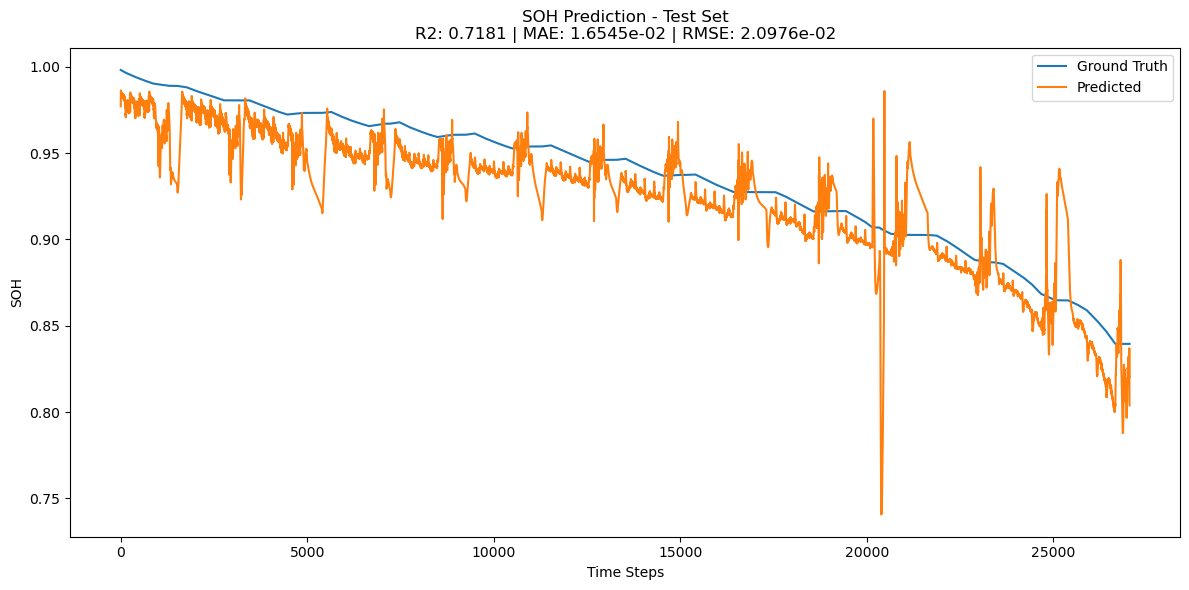

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(true_labels, label='Ground Truth')
plt.plot(predictions, label='Predicted')
plt.title(f"SOH Prediction - Test Set\nR2: {r2:.4f} | MAE: {mae:.4e} | RMSE: {rmse:.4e}")
plt.xlabel('Time Steps')
plt.ylabel('SOH')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
seed_length = 13
pred_length = 10
batch_size = 16  
hidden_dim = 80
num_layers = 5
dropout = 0.5

# Create datasets with appropriate modes
train_dataset = SequenceDataset(train_scaled, seed_len=seed_length, pred_len=pred_length, is_train=True)
val_dataset = SequenceDataset(val_scaled, seed_len=seed_length, pred_len=pred_length, is_train=False)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    drop_last=True
)

val_dataset = SequenceDataset(val_scaled, seed_len=seed_length, pred_len=pred_length, is_train=False)

# Model initialization
model = LSTMSOH(
    input_dim=4,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout,
    pred_len=pred_length
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-3
)

# Train model
history, best_model_state = train_model(
    model, criterion, optimizer,
    train_loader, val_dataset,
    num_epochs=100,
    patience=10,
    seed_length=seed_length,
    pred_length=pred_length 
)

# Save best model
torch.save(best_model_state, "best_model.pth")


Epoch [1/100]
Train Loss: 1.4268e-02
Val Metrics: MAE: 4.3500e-02 | RMSE: 5.4340e-02 | R2: -0.4057
Epoch [2/100]
Train Loss: 1.9494e-03
Val Metrics: MAE: 3.4646e-02 | RMSE: 4.1078e-02 | R2: 0.1967
Epoch [3/100]
Train Loss: 6.3074e-04
Val Metrics: MAE: 6.0723e-02 | RMSE: 7.2105e-02 | R2: -1.4751
Epoch [4/100]
Train Loss: 3.9798e-04
Val Metrics: MAE: 3.4080e-02 | RMSE: 4.0147e-02 | R2: 0.2327
Epoch [5/100]
Train Loss: 3.2346e-04
Val Metrics: MAE: 3.6777e-02 | RMSE: 4.2208e-02 | R2: 0.1519
Epoch [6/100]
Train Loss: 2.8937e-04
Val Metrics: MAE: 3.5765e-02 | RMSE: 4.1223e-02 | R2: 0.1910
Epoch [7/100]
Train Loss: 2.6699e-04
Val Metrics: MAE: 3.5667e-02 | RMSE: 4.2691e-02 | R2: 0.1324
Epoch [8/100]
Train Loss: 2.4578e-04
Val Metrics: MAE: 3.5688e-02 | RMSE: 4.3222e-02 | R2: 0.1107
Epoch [9/100]
Train Loss: 2.9189e-04
Val Metrics: MAE: 3.5080e-02 | RMSE: 4.2529e-02 | R2: 0.1389
Epoch [10/100]
Train Loss: 3.7056e-04
Val Metrics: MAE: 6.8496e-02 | RMSE: 7.9646e-02 | R2: -2.0198
Epoch [11/100]
T

KeyboardInterrupt: 

In [ ]:

##########################################################
# Evaluation
##########################################################  
def test_model(model, test_dataset):
    model.eval()
    
    # 获取测试电池数据
    cell_id = test_dataset.cell_ids[0]  # 只有一个电池
    cell_data = test_dataset.cell_data[cell_id]
    
    # 进行连续预测
    predictions, targets = evaluate_continuous(
        model, cell_data, seed_length, pred_length, device
    )
    
    # 计算指标
    metrics = {
        'r2': r2_score(targets, predictions),
        'mae': mean_absolute_error(targets, predictions),
        'rmse': np.sqrt(mean_squared_error(targets, predictions))
    }
    
    print("\nTest Metrics:")
    print(f"R2: {metrics['r2']:.5f}")
    print(f"MAE: {metrics['mae']:.5e}")
    print(f"RMSE: {metrics['rmse']:.5e}")
    
    return predictions, targets, metrics
# 加载最佳模型进行评估
model.load_state_dict(best_model_state)
test_dataset = SequenceDataset(test_scaled, seed_len=seed_length, pred_len=pred_length, is_train=False)

# 评估模型
predictions, targets, metrics = test_model(model, test_dataset)

# 绘制预测结果
plt.figure(figsize=(12, 6))
plt.plot(targets, label='Ground Truth')
plt.plot(predictions, label='Predicted')
plt.title(f"SOH Prediction - Test Set\nR2: {metrics['r2']:.5f} | MAE: {metrics['mae']:.5e} | RMSE: {metrics['rmse']:.5e}")
plt.xlabel('Time Steps')
plt.ylabel('SOH')
plt.legend()
plt.tight_layout()
plt.show()